In [ ]:
import json
import re
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

# Model and Processor Setup

model_dir = "/home/vishnu/data/llamafactory_env/LLaMA-Factory/saves/Qwen2-VL-2B-Instruct/lora/dpo_sig5/"
model = Qwen2VLForConditionalGeneration.from_pretrained(model_dir).to("cuda")
processor = AutoProcessor.from_pretrained(
    model_dir,
    image_min_pixels=1024,
    image_max_pixels=589824
)
processor.tokenizer.padding_side = 'left'

def patch_tokenizer_and_processor(tokenizer, processor):
    if tokenizer.pad_token is None:
        if tokenizer.eos_token is not None:
            tokenizer.pad_token = tokenizer.eos_token
        else:
            tokenizer.pad_token = "<|endoftext|>"
    if tokenizer.pad_token_id is None:
        if tokenizer.eos_token_id is not None:
            tokenizer.pad_token_id = tokenizer.eos_token_id
        else:
            tokenizer.pad_token_id = 0
    if tokenizer.bos_token_id is None:
        if tokenizer.eos_token_id is not None:
            tokenizer.bos_token_id = tokenizer.eos_token_id
        else:
            tokenizer.bos_token_id = 0
    if tokenizer.eos_token_id is None:
        if hasattr(tokenizer, "eos_token") and tokenizer.eos_token is not None:
            tokenizer.eos_token_id = tokenizer.convert_tokens_to_ids(tokenizer.eos_token)
        else:
            tokenizer.eos_token_id = 0
    processor.pad_token = tokenizer.pad_token
    processor.pad_token_id = tokenizer.pad_token_id
    processor.bos_token_id = tokenizer.bos_token_id
    processor.eos_token_id = tokenizer.eos_token_id

patch_tokenizer_and_processor(processor.tokenizer, processor)

# Helper Functions
def extract_answer(text):
    match = re.search(r"<answer>\s*([A-D])\s*</answer>", text, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    return None

def show_image(image, title=None, size=(6, 6)):
    """Display an image using matplotlib with a specified size."""
    plt.figure(figsize=size)
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def evaluate(
    test_jsonl,
    model,
    processor,
    device="cuda",
    max_new_tokens=256,
    batch_size=4,
    num_visualize=5,
    image_display_size=(6, 6)
):
    """
    Evaluate a test set with image visualizations and print statements.
    Args:
        test_jsonl: Path to the test .jsonl file.
        model: The loaded model.
        processor: The processor.
        device: Device to run on.
        max_new_tokens: Max tokens to generate.
        batch_size: Batch size.
        num_visualize: Number of examples to visualize.
        image_display_size: Tuple (width, height) in inches for image display.
    """
    with open(test_jsonl, "r") as f:
        samples = [json.loads(line) for line in f]
    correct = 0
    total = 0
    visualized = 0
    for i in tqdm(range(0, len(samples), batch_size), desc="Evaluating"):
        batch = samples[i:i+batch_size]
        prompts = [sample["prompt"] for sample in batch]
        def resize_if_needed(img, max_size=768):
            if img.width > max_size or img.height > max_size:
                img.thumbnail((max_size, max_size), Image.LANCZOS)
            return img
        images = [resize_if_needed(Image.open(sample["image_path"]).convert("RGB")) for sample in batch]
        gt_letters = [sample["gt_letter"] for sample in batch]
        text_inputs = [
            processor.apply_chat_template(
                [{"role": "user", "content": [
                    {"type": "image"},
                    {"type": "text", "text": prompt}
                ]}],
                tokenize=False,
                add_generation_prompt=True
            )
            for prompt in prompts
        ]
        inputs = processor(text=text_inputs, images=images, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
        input_len = inputs['input_ids'].shape[1]
        decoded = processor.batch_decode(generated_ids[:, input_len:], skip_special_tokens=True)
        for idx, (pred, gt, prompt, image_path, img) in enumerate(zip(decoded, gt_letters, prompts, [sample["image_path"] for sample in batch], images)):
            pred_letter = extract_answer(pred)
            if pred_letter and gt and pred_letter == gt:
                correct += 1
            total += 1
            if visualized < num_visualize:
                show_image(img, title=f"Example {visualized+1}", size=image_display_size)
                print("Prompt:", prompt[:300], "...")
                print("Ground Truth:", gt)
                print("Model Output:", pred)
                print("Predicted:", pred_letter)
                print("Image Path:", image_path)
                visualized += 1
        del inputs, generated_ids
        torch.cuda.empty_cache()
    accuracy = correct / total if total > 0 else 0
    print(f"\nAccuracy: {accuracy:.4f} ({correct}/{total})")

# Paths to your test JSONL files
test_sets = {
    "MRI (in-domain)": "/home/vishnu/data/llamafactory_env/LLaMA-Factory/testdpo300/test_mri.jsonl",
    "CT (OOD)": "/home/vishnu/data/llamafactory_env/LLaMA-Factory/testdpo300/test_ct.jsonl",
    "X-ray (OOD)": "/home/vishnu/data/llamafactory_env/LLaMA-Factory/testdpo300/test_xray.jsonl"
}

/mnt/vdb/vishnu/llamafactory_env/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Fetching 2 files:   0%|                                                                                                                                                               | 0/2 [00:00<?, ?it/s]


Fetching 2 files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 32140.26it/s]


Loading checkpoint shards:   0%|                                                                                                                                                      | 0/2 [00:00<?, ?it/s]


Loading checkpoint shards:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 1/2 [00:01<00:01,  1.02s/it]


Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.79it/s]


Evaluating on MRI (in-domain)...



Evaluating:   0%|                                                                                                                                                                    | 0/75 [00:00<?, ?it/s]

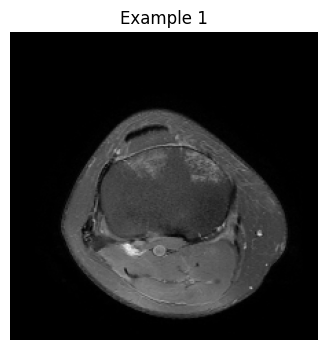

Prompt: <image>
What can be observed in this image?
A) Bone inflammation.
B) Spinal misalignment.
C) Tendonitis.
D) Bursitis.
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B, C, D,...) in ...
Ground Truth: A
Model Output: <think>
The image is a magnetic resonance imaging (MRI) scan of a knee joint. The scan shows a large, fluid-filled structure within the joint, which is characteristic of a bursa. Bursae are sacs that surround joints and contain fluid to reduce friction and provide cushioning.
</think>

<answer>A</answer>
Predicted: A
Image Path: /home/vishnu/data/Images/RadImageNet/bone_inflammation/knee150282.png


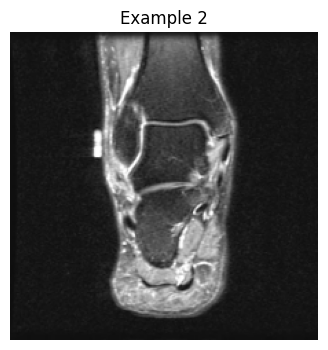

Prompt: <image>
What can be observed in this image?
A) Patellar tendonitis
B) Deltoid pathology
C) Migraine headache
D) Achilles tendonitis
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B ...
Ground Truth: B
Model Output: <think>
The image is a magnetic resonance imaging (MRI) scan of a foot, specifically focusing on the ankle and foot. The scan shows a cross-sectional view of the ankle joint, which is crucial for diagnosing conditions like Achilles tendonitis.
</think>

<answer>D</answer>
Predicted: D
Image Path: /home/vishnu/data/Images/RadImageNet/deltoid_pathology/foot102443.png


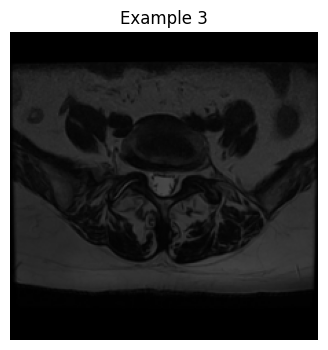

Prompt: <image>
What can be observed in this image?
A) Epidural hematoma
B) Gastric ulcers
C) Osteoporosis
D) Foraminal pathology
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B, C, D,... ...
Ground Truth: D
Model Output: <think>
The image is a MRI scan of the lumbar spine, which is a common imaging technique used to diagnose various spinal conditions. The image shows a cross-sectional view of the lumbar spine, with the vertebral bodies and the surrounding structures visible.
</think>

<answer>
D
</answer>
Predicted: D
Image Path: /home/vishnu/data/Images/RadImageNet/foraminal_pathlogy/spine069615.png


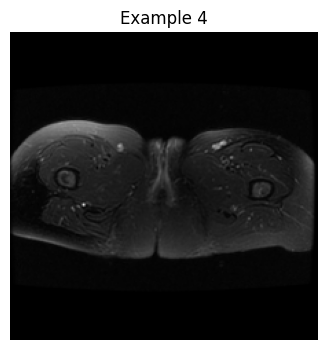


Evaluating:   1%|██                                                                                                                                                          | 1/75 [00:03<04:41,  3.80s/it]

Prompt: <image>
Does this image exhibit any abnormality?
A) I'm not sure, but there might be a slight abnormality.
B) There is a possibility of abnormality, but further tests are needed for confirmation.
C) Yes, it shows a significant abnormality.
D) No, It's normal.
Your task:
1. Think through the question ...
Ground Truth: D
Model Output: <think>
The MRI image shows a cross-sectional view of a human body, likely the lumbar spine. The image appears to be a T2-weighted MRI, which is commonly used to visualize soft tissues and fluid. The image shows a normal appearance of the lumbar spine with no visible abnormalities such as fractures, tumors, or other pathological conditions.
</think>

<answer>D</answer>
Predicted: D
Image Path: /home/vishnu/data/Images/RadImageNet/normal/mri-abd-normal016328.png


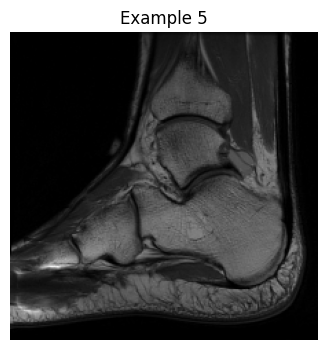

Prompt: <image>
What is the observation in this image?
A) Soft tissue fluid
B) Skin rash
C) Nerve inflammation
D) Bone fracture
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B, C, D,...)  ...
Ground Truth: A
Model Output: <think>
The image is a magnetic resonance imaging (MRI) scan of the ankle. The scan shows a soft tissue structure with fluid-like appearance, which is characteristic of soft tissue fluid.
</think>

<answer>A</answer>
Predicted: A
Image Path: /home/vishnu/data/Images/RadImageNet/soft_tissue_fluid/foot075342.png


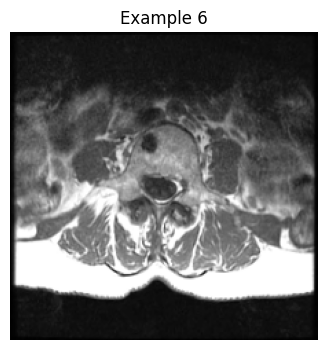

Prompt: <image>
What can be observed in this image?
A) Gastrointestinal abnormality
B) Respiratory abnormality
C) Muscular abnormality
D) Osseous abnormality
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-l ...
Ground Truth: D
Model Output: <think>
The image is a cross-sectional view of a spinal cord, which is a medical imaging technique used to visualize the spinal cord. The image shows the spinal cord with surrounding structures, including the vertebral column and the surrounding muscles and bones.
</think>

<answer>
D
</answer>
Predicted: D
Image Path: /home/vishnu/data/Images/RadImageNet/osseous_abn/spine073983.png


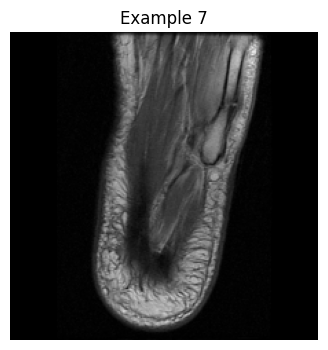

Prompt: <image>
What is the observation evident in this image?
A) Neuralgia
B) Osseous disruption
C) Vascular congestion
D) Cardiac arrhythmia
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A ...
Ground Truth: B
Model Output: <think>
The image is a magnetic resonance imaging (MRI) scan of a foot, showing a cross-sectional view of the ankle joint. The scan shows a structure that appears to be a bone, with a surrounding soft tissue structure. The bone appears to be disrupted, which is indicative of osseous disruption.
</think>

<answer>B</answer>
Predicted: B
Image Path: /home/vishnu/data/Images/RadImageNet/osseous_disruption/ankle004462.png


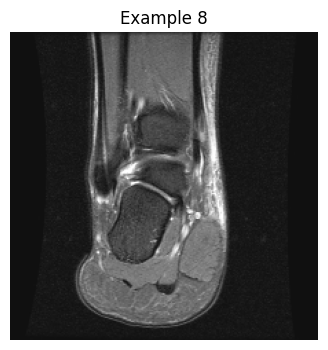


Evaluating:   3%|████▏                                                                                                                                                       | 2/75 [00:06<03:59,  3.28s/it]

Prompt: <image>
What is the visual observation in this picture?
A) Inflammation in the stomach
B) Enlarged lymph node
C) Soft tissue mass
D) Irregular heartbeat
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct singl ...
Ground Truth: C
Model Output: <think>
The image is a medical MRI scan of a foot, showing a soft tissue mass in the ankle joint. The visual observation in this picture is a soft tissue mass.
</think>

<answer>C</answer>
Predicted: C
Image Path: /home/vishnu/data/Images/RadImageNet/soft_tissue_mass/ankle052991.png


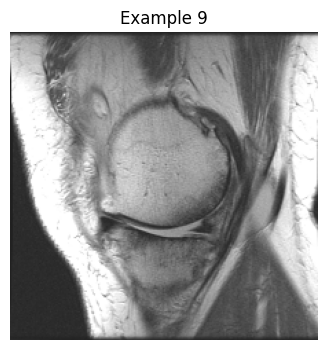

Prompt: <image>
What diagnosis does this picture indicate?
A) Joint inflammation
B) Synovial cyst formation
C) Chondral abnormality
D) Nerve compression
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter ...
Ground Truth: C
Model Output: <think>
The image is a black-and-white MRI scan of a knee joint. The scan shows a large, round, and slightly fluid-filled structure within the joint, which is indicative of a synovial cyst.
</think>

<answer>C</answer>
Predicted: C
Image Path: /home/vishnu/data/Images/RadImageNet/chondral_abnormality/knee071156.png


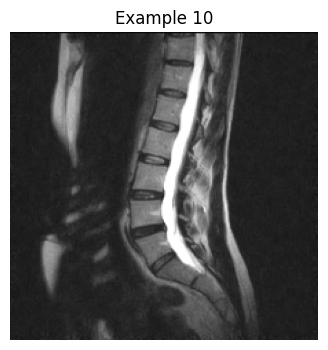


Evaluating:   4%|██████▏                                                                                                                                                     | 3/75 [00:09<03:53,  3.25s/it]

Prompt: <image>
What is the condition that can be identified in this image?
A) Rheumatoid arthritis
B) Osteoporosis
C) Muscular dystrophy
D) Scoliosis
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter c ...
Ground Truth: D
Model Output: <think>
The image is a MRI scan of the lumbar spine, which is a common imaging technique used to diagnose conditions such as spinal disorders, fractures, and other spinal abnormalities.
</think>

<answer>D</answer>
Predicted: D
Image Path: /home/vishnu/data/Images/RadImageNet/scoliosis/spine074513.png



Evaluating:   5%|████████▎                                                                                                                                                   | 4/75 [00:12<03:33,  3.00s/it]


Evaluating:   7%|██████████▍                                                                                                                                                 | 5/75 [00:15<03:22,  2.89s/it]


Evaluating:   8%|████████████▍                                                                                                                                               | 6/75 [00:17<03:14,  2.82s/it]


Evaluating:   9%|██████████████▌                                                                                                                                             | 7/75 [00:20<03:02,  2.69s/it]


Evaluating:  11%|████████████████▋                                                                                                                                           | 8/75 [00:23<03:14,  2.91s/it]


Evaluating:  12%|██████████████████▋                                                                                                                                         | 9/75 [00:26<03:14,  2.95s/it]


Evaluating:  13%|████████████████████▋                                                                                                                                      | 10/75 [00:29<03:10,  2.93s/it]


Evaluating:  15%|██████████████████████▋                                                                                                                                    | 11/75 [00:31<02:56,  2.75s/it]


Evaluating:  16%|████████████████████████▊                                                                                                                                  | 12/75 [00:34<02:56,  2.80s/it]


Evaluating:  17%|██████████████████████████▊                                                                                                                                | 13/75 [00:37<02:47,  2.71s/it]


Evaluating:  19%|████████████████████████████▉                                                                                                                              | 14/75 [00:40<02:48,  2.77s/it]


Evaluating:  20%|███████████████████████████████                                                                                                                            | 15/75 [00:43<02:52,  2.87s/it]


Evaluating:  21%|█████████████████████████████████                                                                                                                          | 16/75 [00:46<02:47,  2.85s/it]


Evaluating:  23%|███████████████████████████████████▏                                                                                                                       | 17/75 [00:48<02:42,  2.81s/it]


Evaluating:  24%|█████████████████████████████████████▏                                                                                                                     | 18/75 [00:52<02:45,  2.91s/it]


Evaluating:  25%|███████████████████████████████████████▎                                                                                                                   | 19/75 [00:54<02:33,  2.74s/it]


Evaluating:  27%|█████████████████████████████████████████▎                                                                                                                 | 20/75 [00:56<02:26,  2.67s/it]


Evaluating:  28%|███████████████████████████████████████████▍                                                                                                               | 21/75 [00:59<02:27,  2.72s/it]


Evaluating:  29%|█████████████████████████████████████████████▍                                                                                                             | 22/75 [01:02<02:23,  2.70s/it]


Evaluating:  31%|███████████████████████████████████████████████▌                                                                                                           | 23/75 [01:05<02:24,  2.78s/it]


Evaluating:  32%|█████████████████████████████████████████████████▌                                                                                                         | 24/75 [01:08<02:21,  2.78s/it]


Evaluating:  33%|███████████████████████████████████████████████████▋                                                                                                       | 25/75 [01:11<02:20,  2.82s/it]


Evaluating:  35%|█████████████████████████████████████████████████████▋                                                                                                     | 26/75 [01:14<02:22,  2.92s/it]


Evaluating:  36%|███████████████████████████████████████████████████████▊                                                                                                   | 27/75 [01:17<02:20,  2.93s/it]


Evaluating:  37%|█████████████████████████████████████████████████████████▊                                                                                                 | 28/75 [01:20<02:30,  3.20s/it]


Evaluating:  39%|███████████████████████████████████████████████████████████▉                                                                                               | 29/75 [01:23<02:19,  3.03s/it]


Evaluating:  40%|██████████████████████████████████████████████████████████████                                                                                             | 30/75 [01:26<02:09,  2.88s/it]


Evaluating:  41%|████████████████████████████████████████████████████████████████                                                                                           | 31/75 [01:28<01:59,  2.73s/it]


Evaluating:  43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 32/75 [01:31<01:54,  2.65s/it]


Evaluating:  44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 33/75 [01:33<01:45,  2.50s/it]


Evaluating:  45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 34/75 [01:36<01:53,  2.77s/it]


Evaluating:  47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 35/75 [01:39<01:47,  2.69s/it]


Evaluating:  48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 36/75 [01:41<01:40,  2.58s/it]


Evaluating:  49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 37/75 [01:44<01:46,  2.79s/it]


Evaluating:  51%|██████████████████████████████████████████████████████████████████████████████▌                                                                            | 38/75 [01:47<01:39,  2.69s/it]


Evaluating:  52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 39/75 [01:50<01:41,  2.81s/it]


Evaluating:  53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 40/75 [01:52<01:37,  2.79s/it]


Evaluating:  55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 41/75 [01:55<01:32,  2.71s/it]


Evaluating:  56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 42/75 [01:58<01:29,  2.70s/it]


Evaluating:  57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 43/75 [02:00<01:24,  2.63s/it]


Evaluating:  59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 44/75 [02:03<01:24,  2.74s/it]


Evaluating:  60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 45/75 [02:06<01:21,  2.72s/it]


Evaluating:  61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                            | 46/75 [02:08<01:16,  2.65s/it]


Evaluating:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 47/75 [02:11<01:15,  2.71s/it]


Evaluating:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 48/75 [02:14<01:13,  2.73s/it]


Evaluating:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 49/75 [02:16<01:09,  2.69s/it]


Evaluating:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 50/75 [02:19<01:07,  2.68s/it]


Evaluating:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 51/75 [02:22<01:03,  2.67s/it]


Evaluating:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 52/75 [02:25<01:04,  2.82s/it]


Evaluating:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 53/75 [02:28<01:02,  2.84s/it]


Evaluating:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 54/75 [02:30<00:55,  2.65s/it]


Evaluating:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 55/75 [02:33<00:55,  2.77s/it]


Evaluating:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 56/75 [02:36<00:53,  2.82s/it]


Evaluating:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 57/75 [02:38<00:48,  2.71s/it]


Evaluating:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 58/75 [02:41<00:47,  2.77s/it]


Evaluating:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59/75 [02:44<00:41,  2.59s/it]


Evaluating:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 60/75 [02:46<00:40,  2.68s/it]


Evaluating:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 61/75 [02:49<00:37,  2.69s/it]


Evaluating:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62/75 [02:52<00:36,  2.83s/it]


Evaluating:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 63/75 [02:55<00:33,  2.81s/it]


Evaluating:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 64/75 [02:58<00:29,  2.69s/it]


Evaluating:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 65/75 [03:00<00:26,  2.65s/it]


Evaluating:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 66/75 [03:03<00:23,  2.60s/it]


Evaluating:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 67/75 [03:06<00:22,  2.77s/it]


Evaluating:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 68/75 [03:09<00:20,  2.86s/it]


Evaluating:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 69/75 [03:11<00:16,  2.76s/it]


Evaluating:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 70/75 [03:14<00:13,  2.63s/it]


Evaluating:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 71/75 [03:16<00:10,  2.63s/it]


Evaluating:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 72/75 [03:19<00:08,  2.75s/it]


Evaluating:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 73/75 [03:22<00:05,  2.65s/it]


Evaluating:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 74/75 [03:24<00:02,  2.61s/it]


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [03:27<00:00,  2.70s/it]


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [03:27<00:00,  2.77s/it]


Accuracy: 0.9467 (284/300)


In [ ]:
print("\nEvaluating on MRI (in-domain)...")
evaluate(
    test_sets["MRI (in-domain)"],
    model,
    processor,
    batch_size=4,
    num_visualize=10,
    image_display_size=(4, 4)  
)


Evaluating on CT (OOD)...



Evaluating:   0%|                                                                                                                                                                    | 0/75 [00:00<?, ?it/s]

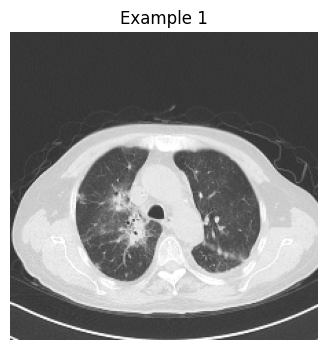

Prompt: <image>
What is the term referring to the abnormality observed in the image?
A) Airspace opacity
B) Pleural effusion
C) Lung consolidation
D) Atelectasis
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct sing ...
Ground Truth: A
Model Output: <think>
The image shows a cross-sectional view of the chest, which is a common imaging technique used in medical diagnostics. The abnormality observed in the image appears as a area of increased density, which is characteristic of a consolidation or a mass. The presence of airspaces and the normal appearance of the pleura suggest that this is not a pleural effusion or a mass effect. The absence of signs of atelectasis (e.g., air trapping) makes it less likely to be a mass effect.
</think>

<answer>A</answer>
Predicted: A
Image Path: /home/vishnu/data/Images/RadImageNet/Airspace_opacity/lung077022.png


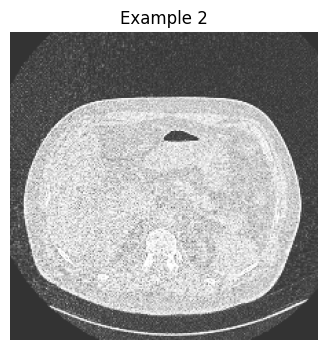

Prompt: <image>
Is there any presence of abnormalities observed in this image?
A) Yes.
B) No
C) nan
D) nan
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B, C, D,...) inside <answer>...</a ...
Ground Truth: B
Model Output: <think>
The image appears to be a cross-sectional view of a human body, likely a CT scan. The image shows a dense, dark area in the center, which could be indicative of a mass or abnormality. However, without further context or a detailed analysis, it's challenging to definitively determine the presence of abnormalities.
</think>

<answer>A</answer>
Predicted: A
Image Path: /home/vishnu/data/Images/RadImageNet/normal/lung-normal029133.png


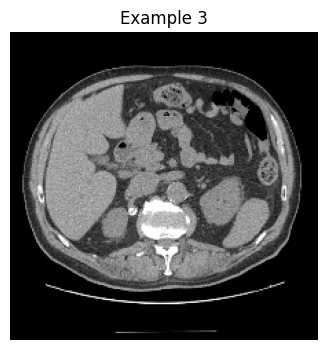

Prompt: <image>
What abnormal finding can be observed in the radiograph?
A) Gastrointestinal pathology
B) Arterial pathology
C) Endocrine pathology
D) Osseous pathology
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the corre ...
Ground Truth: B
Model Output: <think>
The radiograph shows a cross-sectional view of the abdomen, which is a common imaging technique used in medical diagnostics. The image appears to be a CT scan, as indicated by the dense and uniform contrast.
</think>

<answer>D</answer>
Predicted: D
Image Path: /home/vishnu/data/Images/RadImageNet/arterial_pathology/abd012976.png


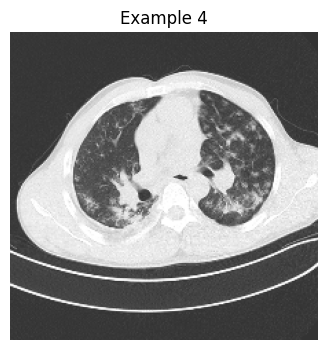


Evaluating:   1%|██                                                                                                                                                          | 1/75 [00:04<05:18,  4.31s/it]

Prompt: <image>
What is the presence in the image indicative of with regard to abnormalities?
A) Airspace opacity
B) Nodule formation
C) Pulmonary embolism
D) Pleural effusion
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide th ...
Ground Truth: A
Model Output: <think>
The image is a CT (Computed Tomography) scan of the chest, which is a medical imaging technique used to visualize internal structures of the body. The scan shows a cross-sectional view of the lungs.
</think>

<answer>A</answer>
Predicted: A
Image Path: /home/vishnu/data/Images/RadImageNet/Airspace_opacity/lung059990.png


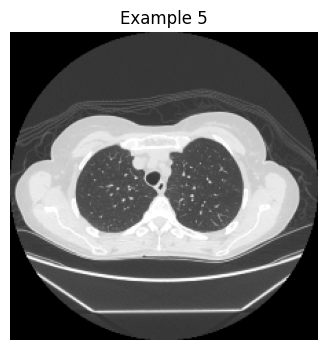

Prompt: <image>
Is there anything abnormal observed in this image?
A) Yes.
B) No
C) nan
D) nan
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B, C, D,...) inside <answer>...</answer> tags. ...
Ground Truth: B
Model Output: <think>
The image appears to be a cross-sectional view of a chest, likely from a CT scan. The image shows a structure that looks like a lung with some areas of density that could be interpreted as abnormal.
</think>

<answer>A</answer>
Predicted: A
Image Path: /home/vishnu/data/Images/RadImageNet/normal/lung-normal047541.png


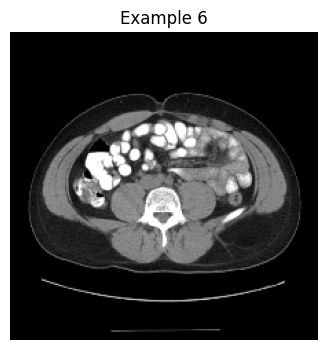

Prompt: <image>
Does this image display any anomalies?
A) Yes.
B) No
C) nan
D) nan
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B, C, D,...) inside <answer>...</answer> tags.
3. No extra ...
Ground Truth: B
Model Output: <think>
The image is a cross-sectional view of the abdomen, which is a common imaging technique used in medical diagnostics. The image shows various structures within the abdomen, including the liver, spleen, and other organs. There are no obvious anomalies visible in the image.
</think>

<answer>A</answer>
Predicted: A
Image Path: /home/vishnu/data/Images/RadImageNet/normal/abd-normal069050.png


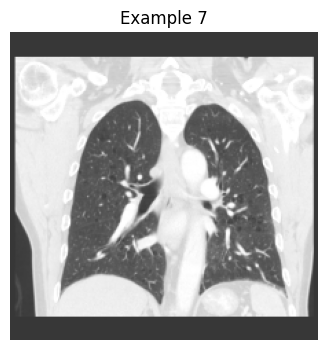

Prompt: <image>
What is the abnormality present in the image?
A) Tissue necrosis
B) Cellular hyperplasia
C) Parenchyma destruction
D) Organ enlargement
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter  ...
Ground Truth: C
Model Output: <think>
The image is a CT scan of the lungs, which is a medical imaging technique used to visualize internal structures of the body. The scan shows a cross-sectional view of the lungs, with the lung fields (the areas where the lungs are located) highlighted in black and the surrounding structures in white.
</think>

<answer>C</answer>
Predicted: C
Image Path: /home/vishnu/data/Images/RadImageNet/Parenchyma_destruction/lung034879.png


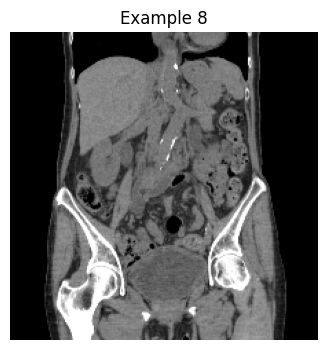


Evaluating:   3%|████▏                                                                                                                                                       | 2/75 [00:07<04:13,  3.47s/it]

Prompt: <image>
What irregularity can be identified in the depicted scan?
A) Contracted urinary tract
B) Dilated urinary tract
C) Enlarged urinary tract
D) Twisted urinary tract
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide  ...
Ground Truth: B
Model Output: <think>
The CT scan depicts a cross-sectional view of the abdomen and pelvis. The image shows a contracted urinary tract, which is indicated by the presence of a narrowed and contracted urinary bladder.
</think>

<answer>A</answer>
Predicted: A
Image Path: /home/vishnu/data/Images/RadImageNet/dilated_urinary_tract/abd092702.png


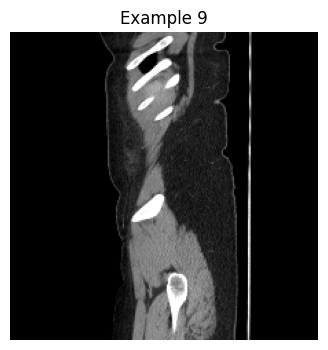

Prompt: <image>
Is there any abnormal finding observed in this image?
A) No
B) Yes.
C) nan
D) nan
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B, C, D,...) inside <answer>...</answer> ta ...
Ground Truth: A
Model Output: <think>
The CT scan image shows a cross-sectional view of the abdomen. The image appears to be a CT scan of the abdomen, which is typically used to diagnose various abdominal conditions. The image shows a normal appearance of the abdominal organs, with no visible abnormalities such as masses, lesions, or other pathological findings.
</think>

<answer>A</answer>
Predicted: A
Image Path: /home/vishnu/data/Images/RadImageNet/normal/abd-normal031186.png


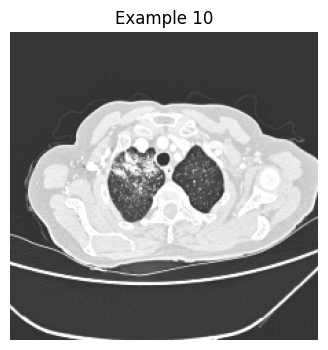


Evaluating:   4%|██████▏                                                                                                                                                     | 3/75 [00:10<03:50,  3.20s/it]

Prompt: <image>
What is the abnormality present in the image?
A) Lung consolidation
B) Airspace opacity
C) Pleural effusion
D) Atelectasis
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B, ...
Ground Truth: B
Model Output: <think>
The image is a cross-sectional view of the chest, likely from a CT scan. The abnormality appears as a area of increased density, which is characteristic of a lung consolidation.
</think>

<answer>B</answer>
Predicted: B
Image Path: /home/vishnu/data/Images/RadImageNet/Airspace_opacity/lung064096.png



Evaluating:   5%|████████▎                                                                                                                                                   | 4/75 [00:12<03:30,  2.97s/it]


Evaluating:   7%|██████████▍                                                                                                                                                 | 5/75 [00:15<03:22,  2.89s/it]


Evaluating:   8%|████████████▍                                                                                                                                               | 6/75 [00:17<03:11,  2.78s/it]


Evaluating:   9%|██████████████▌                                                                                                                                             | 7/75 [00:21<03:31,  3.12s/it]


Evaluating:  11%|████████████████▋                                                                                                                                           | 8/75 [00:24<03:12,  2.87s/it]


Evaluating:  12%|██████████████████▋                                                                                                                                         | 9/75 [00:27<03:15,  2.95s/it]


Evaluating:  13%|████████████████████▋                                                                                                                                      | 10/75 [00:29<03:05,  2.85s/it]


Evaluating:  15%|██████████████████████▋                                                                                                                                    | 11/75 [00:32<02:57,  2.78s/it]


Evaluating:  16%|████████████████████████▊                                                                                                                                  | 12/75 [00:35<03:01,  2.88s/it]


Evaluating:  17%|██████████████████████████▊                                                                                                                                | 13/75 [00:38<02:53,  2.79s/it]


Evaluating:  19%|████████████████████████████▉                                                                                                                              | 14/75 [00:40<02:43,  2.68s/it]


Evaluating:  20%|███████████████████████████████                                                                                                                            | 15/75 [00:43<02:46,  2.78s/it]


Evaluating:  21%|█████████████████████████████████                                                                                                                          | 16/75 [00:46<02:44,  2.79s/it]


Evaluating:  23%|███████████████████████████████████▏                                                                                                                       | 17/75 [00:49<02:40,  2.77s/it]


Evaluating:  24%|█████████████████████████████████████▏                                                                                                                     | 18/75 [00:51<02:34,  2.71s/it]


Evaluating:  25%|███████████████████████████████████████▎                                                                                                                   | 19/75 [00:54<02:25,  2.60s/it]


Evaluating:  27%|█████████████████████████████████████████▎                                                                                                                 | 20/75 [00:57<02:29,  2.72s/it]


Evaluating:  28%|███████████████████████████████████████████▍                                                                                                               | 21/75 [00:59<02:25,  2.70s/it]


Evaluating:  29%|█████████████████████████████████████████████▍                                                                                                             | 22/75 [01:02<02:23,  2.71s/it]


Evaluating:  31%|███████████████████████████████████████████████▌                                                                                                           | 23/75 [01:04<02:13,  2.57s/it]


Evaluating:  32%|█████████████████████████████████████████████████▌                                                                                                         | 24/75 [01:08<02:25,  2.85s/it]


Evaluating:  33%|███████████████████████████████████████████████████▋                                                                                                       | 25/75 [01:11<02:25,  2.91s/it]


Evaluating:  35%|█████████████████████████████████████████████████████▋                                                                                                     | 26/75 [01:13<02:17,  2.81s/it]


Evaluating:  36%|███████████████████████████████████████████████████████▊                                                                                                   | 27/75 [01:16<02:11,  2.75s/it]


Evaluating:  37%|█████████████████████████████████████████████████████████▊                                                                                                 | 28/75 [01:19<02:18,  2.95s/it]


Evaluating:  39%|███████████████████████████████████████████████████████████▉                                                                                               | 29/75 [01:22<02:14,  2.93s/it]


Evaluating:  40%|██████████████████████████████████████████████████████████████                                                                                             | 30/75 [01:25<02:11,  2.92s/it]


Evaluating:  41%|████████████████████████████████████████████████████████████████                                                                                           | 31/75 [01:28<02:06,  2.87s/it]


Evaluating:  43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 32/75 [01:30<01:57,  2.73s/it]


Evaluating:  44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 33/75 [01:33<01:50,  2.64s/it]


Evaluating:  45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 34/75 [01:35<01:46,  2.59s/it]


Evaluating:  47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 35/75 [01:38<01:41,  2.55s/it]


Evaluating:  48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 36/75 [01:40<01:36,  2.48s/it]


Evaluating:  49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 37/75 [01:43<01:36,  2.54s/it]


Evaluating:  51%|██████████████████████████████████████████████████████████████████████████████▌                                                                            | 38/75 [01:45<01:34,  2.56s/it]


Evaluating:  52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 39/75 [01:47<01:27,  2.44s/it]


Evaluating:  53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 40/75 [01:50<01:28,  2.52s/it]


Evaluating:  55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 41/75 [01:53<01:24,  2.48s/it]


Evaluating:  56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 42/75 [01:55<01:22,  2.49s/it]


Evaluating:  57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 43/75 [01:58<01:19,  2.50s/it]


Evaluating:  59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 44/75 [02:01<01:22,  2.67s/it]


Evaluating:  60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 45/75 [02:04<01:22,  2.74s/it]


Evaluating:  61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                            | 46/75 [02:06<01:20,  2.77s/it]


Evaluating:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 47/75 [02:09<01:17,  2.75s/it]


Evaluating:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 48/75 [02:12<01:13,  2.71s/it]


Evaluating:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 49/75 [02:14<01:07,  2.61s/it]


Evaluating:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 50/75 [02:17<01:08,  2.72s/it]


Evaluating:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 51/75 [02:20<01:03,  2.65s/it]


Evaluating:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 52/75 [02:22<00:57,  2.52s/it]


Evaluating:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 53/75 [02:24<00:55,  2.51s/it]


Evaluating:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 54/75 [02:27<00:56,  2.70s/it]


Evaluating:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 55/75 [02:30<00:54,  2.73s/it]


Evaluating:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 56/75 [02:33<00:52,  2.76s/it]


Evaluating:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 57/75 [02:36<00:48,  2.71s/it]


Evaluating:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 58/75 [02:38<00:45,  2.66s/it]


Evaluating:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59/75 [02:42<00:46,  2.88s/it]


Evaluating:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 60/75 [02:44<00:43,  2.88s/it]


Evaluating:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 61/75 [02:47<00:39,  2.80s/it]


Evaluating:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62/75 [02:50<00:38,  2.96s/it]


Evaluating:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 63/75 [02:53<00:35,  2.99s/it]


Evaluating:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 64/75 [02:56<00:31,  2.82s/it]


Evaluating:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 65/75 [02:59<00:27,  2.77s/it]


Evaluating:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 66/75 [03:01<00:23,  2.62s/it]


Evaluating:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 67/75 [03:04<00:22,  2.79s/it]


Evaluating:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 68/75 [03:07<00:20,  2.95s/it]


Evaluating:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 69/75 [03:10<00:17,  2.97s/it]


Evaluating:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 70/75 [03:13<00:14,  2.85s/it]


Evaluating:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 71/75 [03:16<00:11,  2.88s/it]


Evaluating:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 72/75 [03:19<00:08,  2.92s/it]


Evaluating:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 73/75 [03:22<00:06,  3.10s/it]


Evaluating:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 74/75 [03:25<00:02,  2.95s/it]


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [03:28<00:00,  2.86s/it]


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [03:28<00:00,  2.78s/it]


Accuracy: 0.7667 (230/300)


In [3]:
print("\nEvaluating on CT (OOD)...")
evaluate(
    test_sets["CT (OOD)"],
    model,
    processor,
    batch_size=4,
    num_visualize=10,
    image_display_size=(4, 4)
)


Evaluating on X-ray (OOD)...



Evaluating:   0%|                                                                                                                                                                    | 0/75 [00:00<?, ?it/s]

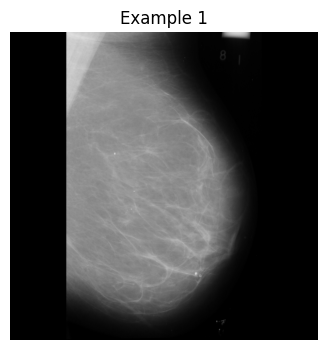

Prompt: <image>
What type of abnormality is depicted in this image?
A) Infection
B) No, It's normal
C) Genetic mutation
D) Congenital defect
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A,  ...
Ground Truth: B
Model Output: <think>
The image is a mammogram, which is used to diagnose breast cancer. The image shows a normal appearance of the breast with no signs of abnormal masses, masses, or other abnormalities.
</think>

<answer>B</answer>
Predicted: B
Image Path: /home/vishnu/data/Images/MIAS/mdb294.png


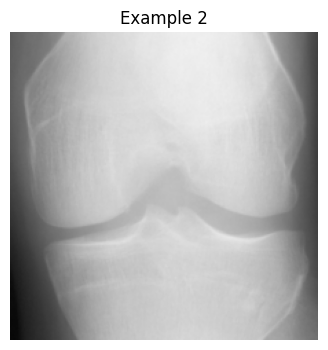

Prompt: <image>
What imaging technique is employed to obtain this picture?
A) Angiography
B) Arthroscopy
C) x_ray.
D) Thermography
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B, C, D,.. ...
Ground Truth: C
Model Output: <think>
The image appears to be a radiographic image, likely a knee x-ray, given the anatomical structures visible.
</think>

<answer>C</answer>
Predicted: C
Image Path: /home/vishnu/data/Images/Knee Osteoarthritis/val/0/9726175L.png


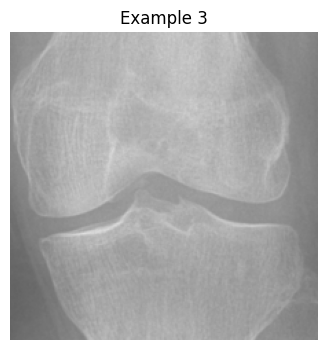

Prompt: <image>
What modality is used to capture this image?
A) x_ray.
B) Cystography
C) Endoscopy
D) Myelogram
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B, C, D,...) inside <answer>. ...
Ground Truth: A
Model Output: <think>
The image appears to be a radiographic image, likely a knee X-ray, given the anatomical structures visible.
</think>

<answer>A</answer>
Predicted: A
Image Path: /home/vishnu/data/Images/Knee Osteoarthritis/val/1/9962232L.png


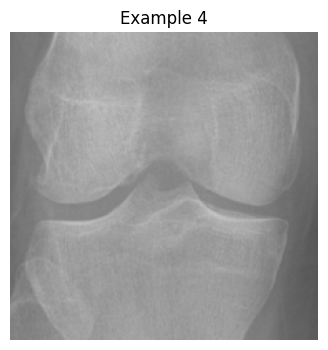


Evaluating:   1%|██                                                                                                                                                          | 1/75 [00:03<04:10,  3.39s/it]

Prompt: <image>
What imaging technique is utilized to obtain this picture?
A) Ultrasound
B) x_ray.
C) Gastrografin swallow
D) Barium swallow
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A,  ...
Ground Truth: B
Model Output: <think>
The image appears to be a radiographic image, which is typically obtained using an x-ray technique. X-rays are used to create images of the inside of the body, including bones and soft tissues.
</think>

<answer>B</answer>
Predicted: B
Image Path: /home/vishnu/data/Images/Knee Osteoarthritis/test/2/9627152R.png


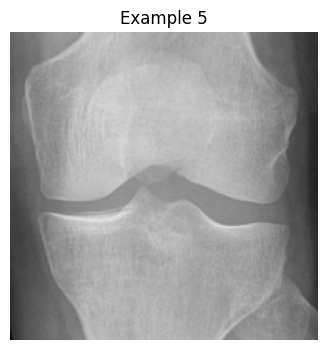

Prompt: <image>
What imaging technique is utilized to capture this picture?
A) Arthroscopy
B) Myelogram
C) x_ray.
D) SPECT scan
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B, C, D,...)  ...
Ground Truth: C
Model Output: <think>
The image appears to be a radiographic view, likely an x-ray, given the grayscale and the way the bones are depicted.
</think>

<answer>C</answer>
Predicted: C
Image Path: /home/vishnu/data/Images/Knee Osteoarthritis/test/0/9300212L.png


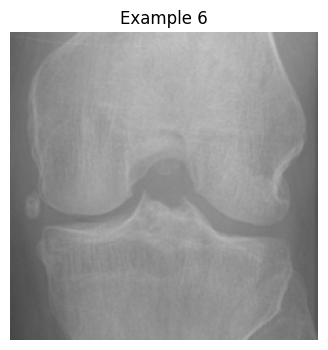

Prompt: <image>
What imaging technique was employed to obtain this picture?
A) Cystography
B) SPECT scan
C) x_ray.
D) Myelogram
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B, C, D,...)  ...
Ground Truth: C
Model Output: <think>
The image appears to be a radiographic image, likely a knee x-ray, given the anatomical structures visible.
</think>

<answer>C</answer>
Predicted: C
Image Path: /home/vishnu/data/Images/Knee Osteoarthritis/test/2/9705415L.png


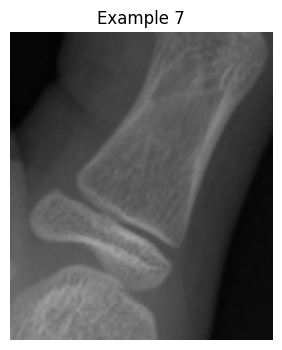

Prompt: <image>
Which imaging technique was utilized to obtain this picture?
A) x_ray.
B) Nuclear Medicine scan
C) Endoscopy
D) Echocardiogram
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A ...
Ground Truth: A
Model Output: <think>
The image appears to be an X-ray of a human foot, which is a common imaging technique used to diagnose conditions such as fractures, dislocations, and other injuries.
</think>

<answer>A</answer>
Predicted: A
Image Path: /home/vishnu/data/Images/RUS CHN/PIPFirst/8/PIPFirst_798168.png


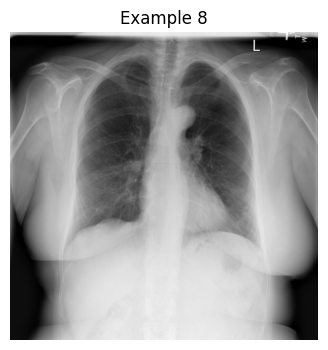


Evaluating:   3%|████▏                                                                                                                                                       | 2/75 [00:07<04:44,  3.90s/it]

Prompt: <image>
Is there any indication of a deviation in this image?
A) Yes.
B) No, It's normal
C) nan
D) nan
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B, C, D,...) inside <answer>.. ...
Ground Truth: B
Model Output: <think>
The image is a chest X-ray, which is a medical imaging technique used to visualize the structures inside the chest. The X-ray shows the lungs, heart, and other structures clearly. The image appears to be a standard chest X-ray, with no obvious abnormalities such as fractures, tumors, or other pathological conditions.
</think>

<answer>B</answer>
Predicted: B
Image Path: /home/vishnu/data/Images/Chest X-Ray PA/normal/00000275_004.png


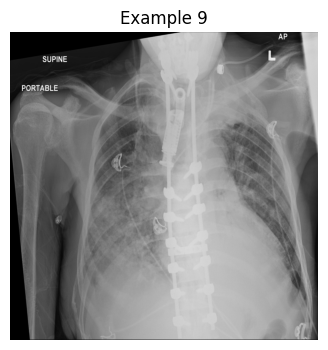

Prompt: <image>
What body region is shown in this picture?
A) Leg
B) Chest
C) Back
D) Abdomen
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the correct single-letter choice (A, B, C, D,...) inside <answer>...</answer> tags.
 ...
Ground Truth: B
Model Output: <think>
The image is a radiograph of a human chest, which is shown in the picture.
</think>

<answer>B</answer>
Predicted: B
Image Path: /home/vishnu/data/Images/COVIDx CXR-4/test/6804008c-94eb-4870-ba6e-b06514073e71.png


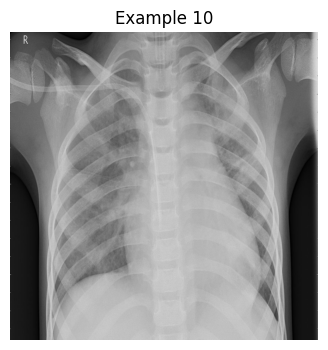


Evaluating:   4%|██████▏                                                                                                                                                     | 3/75 [00:12<05:25,  4.53s/it]

Prompt: <image>
What is the diagnosis for the patient in this image?
A) Viral_Pneumonia.
B) Pulmonary embolism
C) Asthma
D) Chronic obstructive pulmonary disease (COPD)
Your task:
1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags.
2. Then provide the corre ...
Ground Truth: A
Model Output: <think>
The image is a chest X-ray of a patient. The patient appears to have a normal chest cavity with no obvious signs of infection, such as fluid or masses. The lungs appear clear, and there are no signs of consolidation or other abnormalities.
</think>

<answer>B</answer>
Predicted: B
Image Path: /home/vishnu/data/Images/Covid19 heywhale/Viral_Pneumonia/Viral Pneumonia (936).png



Evaluating:   5%|████████▎                                                                                                                                                   | 4/75 [00:18<05:50,  4.94s/it]


Evaluating:   7%|██████████▍                                                                                                                                                 | 5/75 [00:25<06:30,  5.58s/it]


Evaluating:   8%|████████████▍                                                                                                                                               | 6/75 [00:30<06:06,  5.32s/it]


Evaluating:   9%|██████████████▌                                                                                                                                             | 7/75 [00:34<05:39,  5.00s/it]


Evaluating:  11%|████████████████▋                                                                                                                                           | 8/75 [00:39<05:36,  5.02s/it]


Evaluating:  12%|██████████████████▋                                                                                                                                         | 9/75 [00:44<05:32,  5.04s/it]


Evaluating:  13%|████████████████████▋                                                                                                                                      | 10/75 [00:49<05:26,  5.03s/it]


Evaluating:  15%|██████████████████████▋                                                                                                                                    | 11/75 [00:53<05:05,  4.77s/it]


Evaluating:  16%|████████████████████████▊                                                                                                                                  | 12/75 [00:57<04:34,  4.36s/it]


Evaluating:  17%|██████████████████████████▊                                                                                                                                | 13/75 [01:00<04:15,  4.13s/it]


Evaluating:  19%|████████████████████████████▉                                                                                                                              | 14/75 [01:04<03:58,  3.92s/it]


Evaluating:  20%|███████████████████████████████                                                                                                                            | 15/75 [01:07<03:52,  3.87s/it]


Evaluating:  21%|█████████████████████████████████                                                                                                                          | 16/75 [01:11<03:35,  3.66s/it]


Evaluating:  23%|███████████████████████████████████▏                                                                                                                       | 17/75 [01:16<04:06,  4.24s/it]


Evaluating:  24%|█████████████████████████████████████▏                                                                                                                     | 18/75 [01:22<04:21,  4.58s/it]


Evaluating:  25%|███████████████████████████████████████▎                                                                                                                   | 19/75 [01:26<04:10,  4.48s/it]


Evaluating:  27%|█████████████████████████████████████████▎                                                                                                                 | 20/75 [01:30<04:08,  4.52s/it]


Evaluating:  28%|███████████████████████████████████████████▍                                                                                                               | 21/75 [01:36<04:16,  4.76s/it]


Evaluating:  29%|█████████████████████████████████████████████▍                                                                                                             | 22/75 [01:40<04:01,  4.56s/it]


Evaluating:  31%|███████████████████████████████████████████████▌                                                                                                           | 23/75 [01:44<03:53,  4.49s/it]


Evaluating:  32%|█████████████████████████████████████████████████▌                                                                                                         | 24/75 [01:50<04:05,  4.81s/it]


Evaluating:  33%|███████████████████████████████████████████████████▋                                                                                                       | 25/75 [01:54<03:54,  4.70s/it]


Evaluating:  35%|█████████████████████████████████████████████████████▋                                                                                                     | 26/75 [01:58<03:36,  4.42s/it]


Evaluating:  36%|███████████████████████████████████████████████████████▊                                                                                                   | 27/75 [02:03<03:37,  4.53s/it]


Evaluating:  37%|█████████████████████████████████████████████████████████▊                                                                                                 | 28/75 [02:07<03:31,  4.51s/it]


Evaluating:  39%|███████████████████████████████████████████████████████████▉                                                                                               | 29/75 [02:12<03:38,  4.75s/it]


Evaluating:  40%|██████████████████████████████████████████████████████████████                                                                                             | 30/75 [02:16<03:18,  4.40s/it]


Evaluating:  41%|████████████████████████████████████████████████████████████████                                                                                           | 31/75 [02:19<02:58,  4.07s/it]


Evaluating:  43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 32/75 [02:24<02:59,  4.17s/it]


Evaluating:  44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 33/75 [02:27<02:49,  4.04s/it]


Evaluating:  45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 34/75 [02:31<02:44,  4.01s/it]


Evaluating:  47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 35/75 [02:35<02:41,  4.03s/it]


Evaluating:  48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 36/75 [02:40<02:46,  4.27s/it]


Evaluating:  49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 37/75 [02:45<02:42,  4.28s/it]


Evaluating:  51%|██████████████████████████████████████████████████████████████████████████████▌                                                                            | 38/75 [02:49<02:39,  4.32s/it]


Evaluating:  52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 39/75 [02:53<02:34,  4.29s/it]


Evaluating:  53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 40/75 [02:56<02:17,  3.94s/it]


Evaluating:  55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 41/75 [03:02<02:31,  4.44s/it]


Evaluating:  56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 42/75 [03:07<02:28,  4.50s/it]


Evaluating:  57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 43/75 [03:13<02:45,  5.16s/it]


Evaluating:  59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 44/75 [03:18<02:33,  4.95s/it]


Evaluating:  60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 45/75 [03:23<02:28,  4.95s/it]


Evaluating:  61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                            | 46/75 [03:28<02:26,  5.06s/it]


Evaluating:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 47/75 [03:33<02:17,  4.89s/it]


Evaluating:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 48/75 [03:37<02:06,  4.67s/it]


Evaluating:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 49/75 [03:41<02:01,  4.68s/it]


Evaluating:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 50/75 [03:46<01:54,  4.59s/it]


Evaluating:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 51/75 [03:51<01:51,  4.65s/it]


Evaluating:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 52/75 [03:54<01:41,  4.43s/it]


Evaluating:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 53/75 [03:59<01:41,  4.60s/it]


Evaluating:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 54/75 [04:04<01:38,  4.68s/it]


Evaluating:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 55/75 [04:08<01:30,  4.53s/it]


Evaluating:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 56/75 [04:13<01:25,  4.48s/it]


Evaluating:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 57/75 [04:18<01:23,  4.62s/it]


Evaluating:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 58/75 [04:22<01:18,  4.64s/it]


Evaluating:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59/75 [04:27<01:11,  4.45s/it]


Evaluating:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 60/75 [04:30<01:00,  4.02s/it]


Evaluating:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 61/75 [04:33<00:54,  3.89s/it]


Evaluating:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62/75 [04:37<00:50,  3.89s/it]


Evaluating:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 63/75 [04:41<00:46,  3.91s/it]


Evaluating:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 64/75 [04:44<00:40,  3.70s/it]


Evaluating:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 65/75 [04:50<00:42,  4.28s/it]


Evaluating:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 66/75 [04:54<00:39,  4.36s/it]


Evaluating:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 67/75 [05:00<00:38,  4.81s/it]


Evaluating:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 68/75 [05:05<00:32,  4.69s/it]


Evaluating:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 69/75 [05:10<00:29,  4.95s/it]


Evaluating:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 70/75 [05:13<00:22,  4.41s/it]


Evaluating:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 71/75 [05:19<00:18,  4.73s/it]


Evaluating:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 72/75 [05:22<00:12,  4.15s/it]


Evaluating:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 73/75 [05:25<00:08,  4.08s/it]


Evaluating:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 74/75 [05:31<00:04,  4.56s/it]


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [05:37<00:00,  5.00s/it]


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [05:37<00:00,  4.50s/it]


Accuracy: 0.7600 (228/300)


In [4]:
print("\nEvaluating on X-ray (OOD)...")
evaluate(
    test_sets["X-ray (OOD)"],
    model,
    processor,
    batch_size=4,
    num_visualize=10,
    image_display_size=(4, 4)
)